In [2]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)



In [3]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.log_pr_10")
volu = pd.read_pickle("./volume_usd.df")

In [93]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean(0)
    iqr = dta.quantile([0.25, 0.75], axis=0).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [303]:
def train_preprocess_dta(dta, smooth_freq='10T', scale=100, rolling_dt=5):
    """
    returns preprocessed log price and generated volatility
    dta (pd)
    """
    log_pr_dta = dta.resample(smooth_freq).mean().rename(columns={f"log_pr_{i}": i for i in range(10)})
    log_pr_dta = log_pr_dta.diff() * scale
    vol_pr_dta = log_pr_dta.rolling(rolling_dt).std().rename(columns={f"vol_pr_{i}": i for i in range(10)})
    df = pd.concat([log_pr_dta, vol_pr_dta], axis=1)
    df_ro = remove_outliers(df).dropna()

    return df_ro.iloc[:,:10], df_ro.iloc[:,10:]

    # log_pr_dta_ro = remove_outliers(log_pr_dta.iloc[(rolling_dt-1):]).dropna()
    # vol_pr_dta_ro = remove_outliers(vol_pr_dta.iloc[(rolling_dt-1):]).dropna()

    # print(log_pr_dta_ro.shape)
    # print(vol_pr_dta_ro.shape)
    # return log_pr_dta_ro, vol_pr_dta_ro

In [305]:
def test_preprocess_dta(dta, smooth_freq='10T', scale=100, rolling_dt=5):

    log_pr_dta = dta.resample(smooth_freq).mean().rename(columns={f"log_pr_{i}": i for i in range(10)})
    log_pr_dta = log_pr_dta.diff() * scale
    vol_pr_dta = log_pr_dta.rolling(rolling_dt).std().rename(columns={f"vol_pr_{i}": i for i in range(10)})
    df = pd.concat([log_pr_dta, vol_pr_dta], axis=1).dropna()

    return df.iloc[:,:10], df.iloc[:,10:]

In [309]:
def group_dta(dta, stock_dict):
    """ group data according to group of stock
    dta (pd): ncol = #stocks
    stock_dict (dict): dictionary, key is assigned group idx, value is stock idx

    returns:
    dta_dict (dict): dictionary of df, key is group idx
    """
    # key_name = np.fromiter(stock_dict.values(), dtype=int).unique()
    # dta_dict = {i:[] for i in key_name}
    dta_dict = {}
    for key, idx in stock_dict.items():
        dta_dict[key] = dta[idx]

    return dta_dict


In [310]:
def train_test_split(dta, n_test):
    """
    dta (pd): log return
    n_test (int): number of test examples
    stock_dict (dict): dictionary, key is stock idx, value is assigned group
    """
    dta_train = dta.iloc[:-n_test]
    dta_test = dta.iloc[-n_test:]
    return dta_train, dta_test


In [311]:
def transform_back_dta(pred_vol, scale=100):
    """
    transform back the predicted volatility (the last prediction is in 30 mins)
    to time series, following an AR process
    input:
    pred_vol (ndarray): nrow=step, ncol=#stocks

    return:
    30 mins return
    """
    # times gaussian innovation at each step gives AR process with heteroskedaticity
    vol_30 = np.cumsum(pred_vol * np.random.normal(0, 1, pred_vol.shape), axis=0)[-1].squeeze()
    return vol_30/scale


In [312]:
from statsmodels.tsa.api import VAR

def train_VAR(pr_train_dict, maxlags):
    """
    vol_pr_train_dict (dict): the dictionary key is the grouping idx of 10 stocks
    """
    res_dict = {}
    for key, pr_train in pr_train_dict.items():
        model = VAR(pr_train)
        res_dict[key] = model.fit(maxlags, ic='aic')

    return res_dict
    

In [313]:
def forcast_VAR(pr_test_dict, model_dict, step=3):
    """
    vol_pr_test_dict (dict): dictionary of test vol dta, key is group idx
    model_dict (dict): dictionary of model
    step (int): number of forward prediction
    """
    pred_dict = {}
    for idx, model in model_dict.items():
        pred_dict[idx] = model.forecast(pr_test_dict.get(idx).values, step)
    return pred_dict

In [314]:

def get_r_hat_VAR(stock_dict, model_dict, X_pr_day, X_vol_day=None):
    scale = 100
    smooth = 1
    step = 30//smooth

    log_pr2_dta, vol_pr_dta = train_preprocess_dta(X_pr_day, smooth_freq='1T', scale=scale, rolling_dt=5)
    log_pr2_test_dict = group_dta(log_pr2_dta, stock_dict)
    pred_dict = forcast_VAR(log_pr2_test_dict, model_dict, step=step)
    
    out = np.zeros(10)
    vol = np.zeros(shape=(10,30))
    for keys, idx in stock_dict.items():
        out[idx] = transform_back_dta(pred_dict.get(keys))   
        vol[idx] = (pred_dict.get(keys)/scale).T

    return out, vol.T

### Train

Firstly, preprocess the data

In [363]:
n_test = 1440 * 30 # last month as test dataset
# stock_dict = {0:[2,5,6,9], 1:[0,1,3,4,8,7]}
stock_dict = {0:[0,1,2,3,4,5,6,7,8,9]}
smooth_freq = '1T'
scale = 100
rolling_dt = 5


log_pr_train, log_pr_test = train_test_split(log_pr, n_test)
log_pr2_train, vol_pr_train = train_preprocess_dta(log_pr_train, smooth_freq, scale, rolling_dt)
log_pr2_test, vol_pr_test = test_preprocess_dta(log_pr_test, smooth_freq, scale, rolling_dt)

grp_log_pr2_train = group_dta(log_pr2_train, stock_dict)
grp_vol_pr_train = group_dta(vol_pr_train, stock_dict)


(219114, 20)


Then we fit the model

In [364]:
max_lags = 50

mod_dict = train_VAR(grp_log_pr2_train, max_lags)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Forecast

In [365]:
t = log_pr2_train.index[1440]
dt = datetime.timedelta(days=1)
dta_test = log_pr2_train.loc[(t - dt):t]

pred = get_r_hat_VAR(stock_dict, mod_dict, dta_test, X_vol_day=None)

(1408, 20)


In [366]:
dta_test.shape

(1423, 10)

In [367]:
t_30 = log_pr2_train.index[1441]
dt_30 = datetime.timedelta(minutes=29)
true_vol = vol_pr_train.loc[t_30:(t_30+dt_30)]
pred_vol = pred[1]

In [368]:
for i in range(10):
    print(np.sqrt(mse(pred_vol[:,i], true_vol.values[:,i])))

0.04296330750271073
0.06836667715223825
0.047677753311209624
0.05724272677291968
0.05242050294763781
0.041432918046376506
0.059833353423110226
0.06020371333088571
0.032439395581400646
0.025214407559796714


this looks soo baaad

In [369]:
true_pr = log_pr2_train.loc[t_30+dt_30] - log_pr2_train.loc[t_30]
pred_pr = pred[0]

In [370]:
pred_pr

array([ 1.21591108e-03, -7.83540258e-03, -3.51414591e-03, -5.46711201e-05,
       -1.03833413e-02, -5.09755330e-03,  2.35951553e-03,  5.29731583e-03,
        3.46607473e-03,  8.67687084e-04])

In [371]:
true_pr

0    0.007331
1   -0.036568
2   -0.026877
3   -0.042287
4    0.040065
5    0.028136
6    0.006152
7   -0.065879
8    0.027346
9    0.049581
dtype: float64

In [372]:
np.corrcoef(true_pr, pred_pr)

array([[ 1.        , -0.21067793],
       [-0.21067793,  1.        ]])

In [348]:
r_fwd = (log_pr_train.shift(-30) - log_pr_train).iloc[1440::10]
r_fwd.iloc[0]

0   -0.000044
1   -0.004690
2   -0.004387
3    0.001686
4    0.000899
5   -0.000343
6   -0.003212
7   -0.000210
8   -0.000760
9    0.000426
Name: 2021-07-02 00:00:00, dtype: float64

In [248]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)

r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.arange(10), dtype=np.float64)

for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat_VAR(stock_dict, mod_dict, log_pr_test.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)

5.883288145065308


In [251]:
r_fwd.corrwith(r_hat)

0   -0.031277
1    0.011508
2    0.026347
3    0.005388
4    0.078933
5   -0.011377
6   -0.023981
7    0.017293
8   -0.034209
9    0.035171
dtype: float64

In [252]:
r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)

array([[1.       , 0.0066954],
       [0.0066954, 1.       ]])

# Archived Code

<AxesSubplot:xlabel='timestamp'>

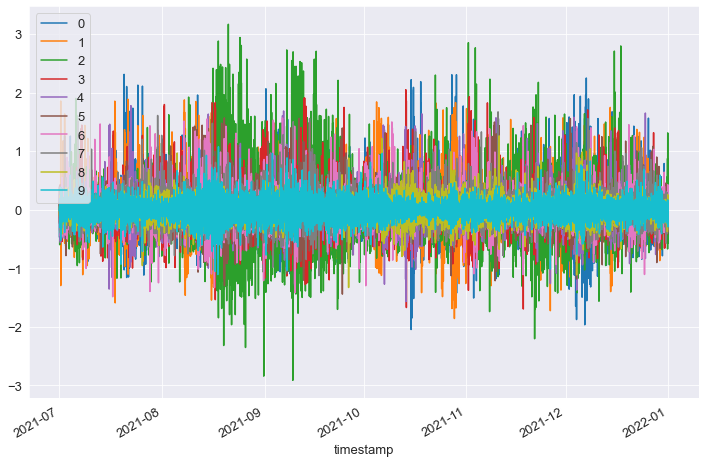

In [15]:
scale = 100
smooth = 5

log_pr_10 = log_pr.resample('10T').mean()
log_pr_10 = remove_outliers(log_pr_10.diff()).dropna() * scale
log_pr_10.plot(figsize=(12, 8))

<AxesSubplot:xlabel='timestamp'>

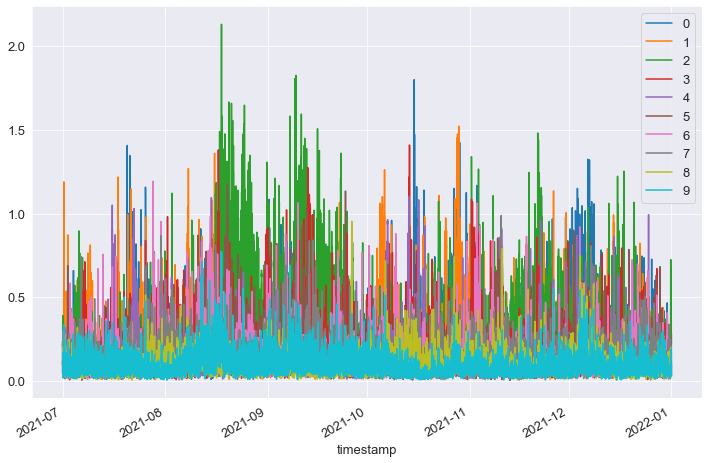

In [33]:
vol_pr_5 = log_pr_10.rolling(smooth).std().iloc[4:]
vol_pr_5.plot(figsize=(12, 8))

## We analyse the data

In [18]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

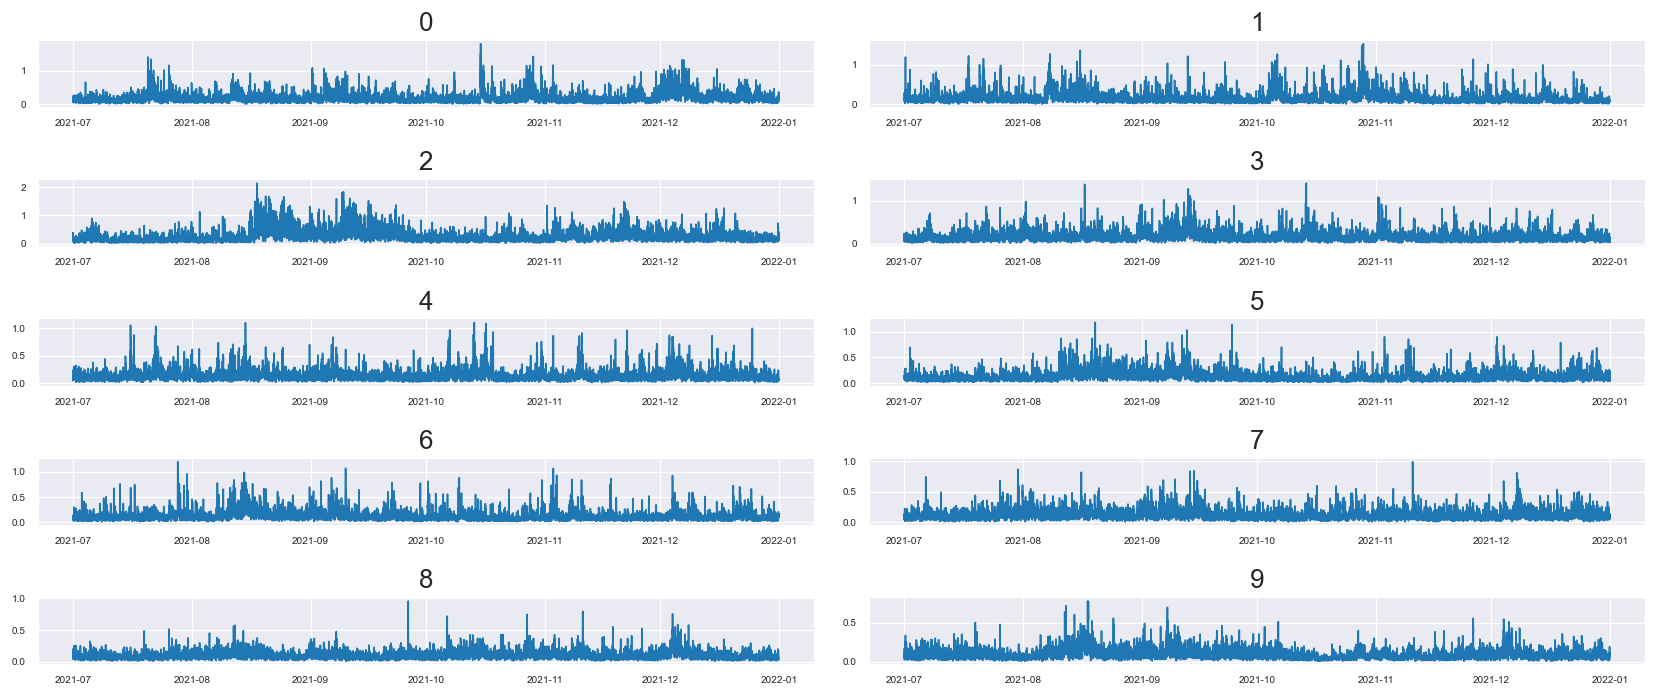

In [21]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):
    data = vol_pr_5[vol_pr_5.columns[i]]
    ax.plot(data, linewidth=1)
    # Decorations
    ax.set_title(vol_pr_5.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

#### Granger Causality Test

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=50, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var for var in variables]
    df.index = [var for var in variables]
    return df


In [35]:
maxlag = 30
test = 'ssr_chi2test'

df_pr = grangers_causation_matrix(vol_pr_5, variables = vol_pr_5.columns)  
df_pr

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0000,0.0001,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000
1,0.0,1.0000,0.0039,0.0000,0.0001,0.0,0.0000,0.0014,0.0000,0.0001
2,0.0,0.0045,1.0000,0.0001,0.0987,0.0,0.0026,0.0002,0.0119,0.0000
3,0.0,0.0033,0.0000,1.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000
4,0.0,0.0000,0.1322,0.0000,1.0000,0.0,0.0000,0.0000,0.0000,0.0000
5,0.0,0.0000,0.0000,0.0000,0.0000,1.0,0.0000,0.0000,0.0000,0.0000
6,0.0,0.0000,0.0000,0.0000,0.0000,0.0,1.0000,0.0000,0.0000,0.0000
7,0.0,0.0015,0.0009,0.0000,0.0000,0.0,0.0000,1.0000,0.0000,0.0000
8,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,1.0000,0.0000
9,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,1.0000


#### Test of stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller
for i in range(10):
    result = adfuller((log_pr_10**2)[i], autolag='AIC')
    # print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    # print(f'n_lags: {result[1]}')
    # print(f'p-value: {result[1]}')
    # for key, value in result[4].items():
    #     print('Critial Values:')
    #     print(f'   {key}, {value}')    

p-value: 2.5319392085026536e-24
p-value: 3.7208129869260096e-26
p-value: 1.1235043945594101e-20
p-value: 7.182746321345531e-30
p-value: 1.0772502597850143e-27
p-value: 1.2603224229343798e-27
p-value: 2.0366613189858953e-29
p-value: 4.4035548964532996e-30
p-value: 8.155563439614467e-29
p-value: 1.5274918322338153e-26


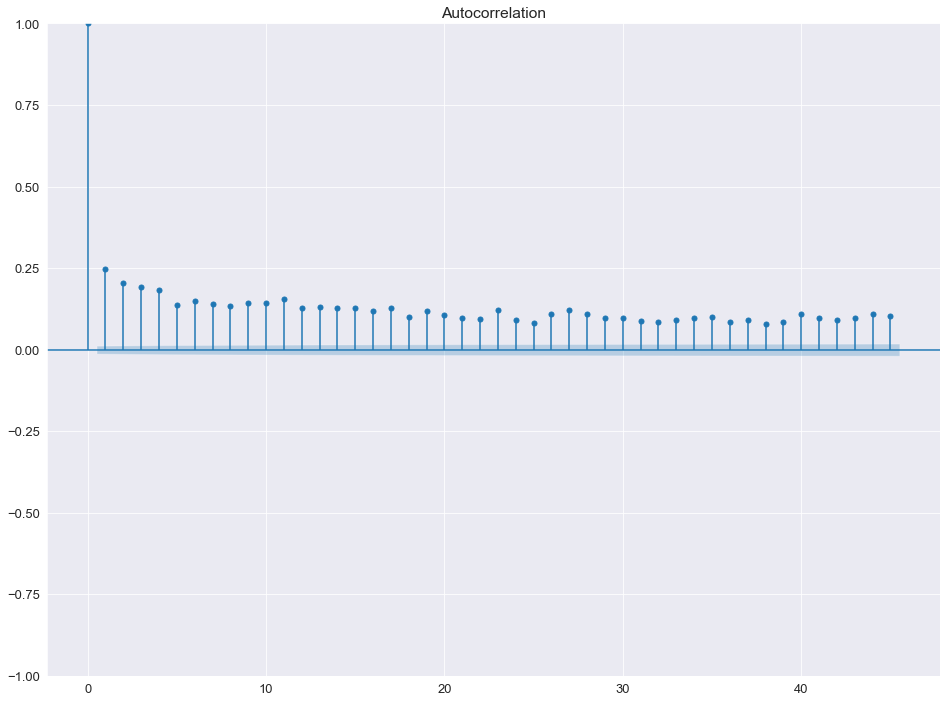

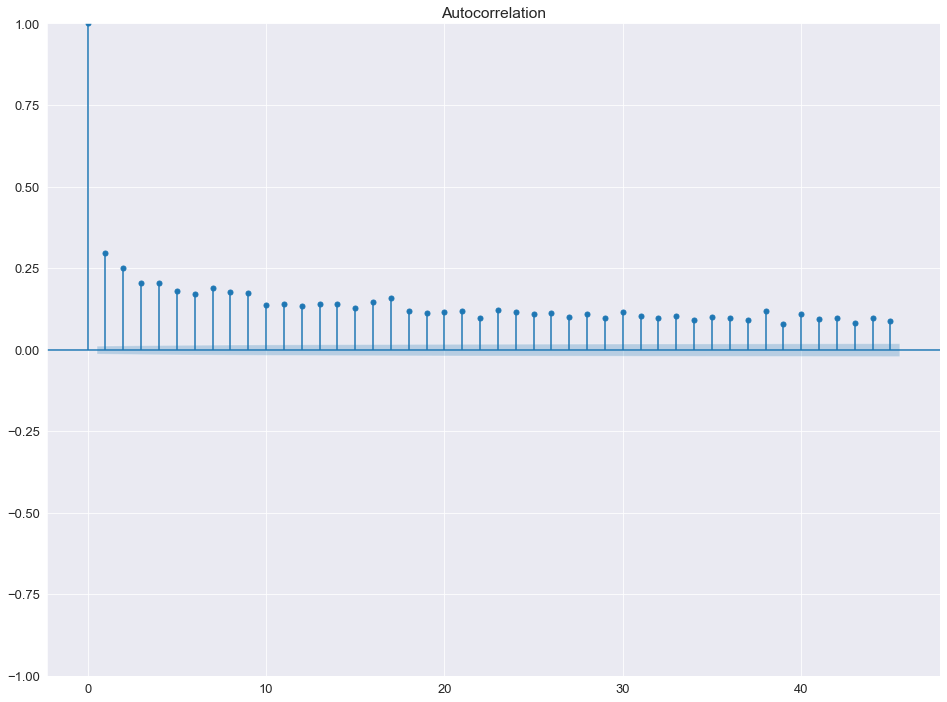

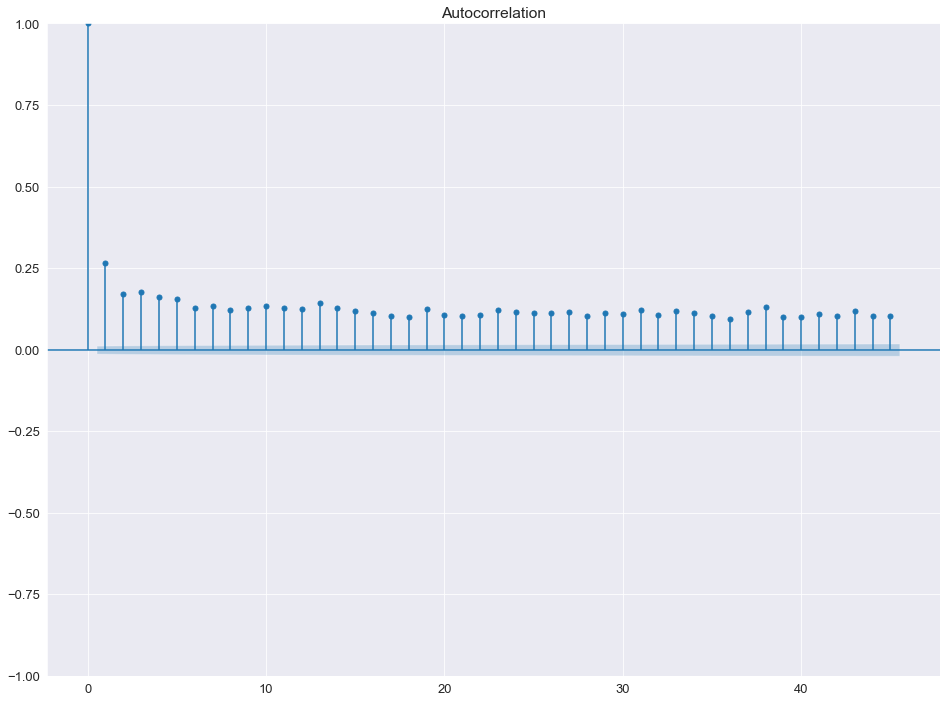

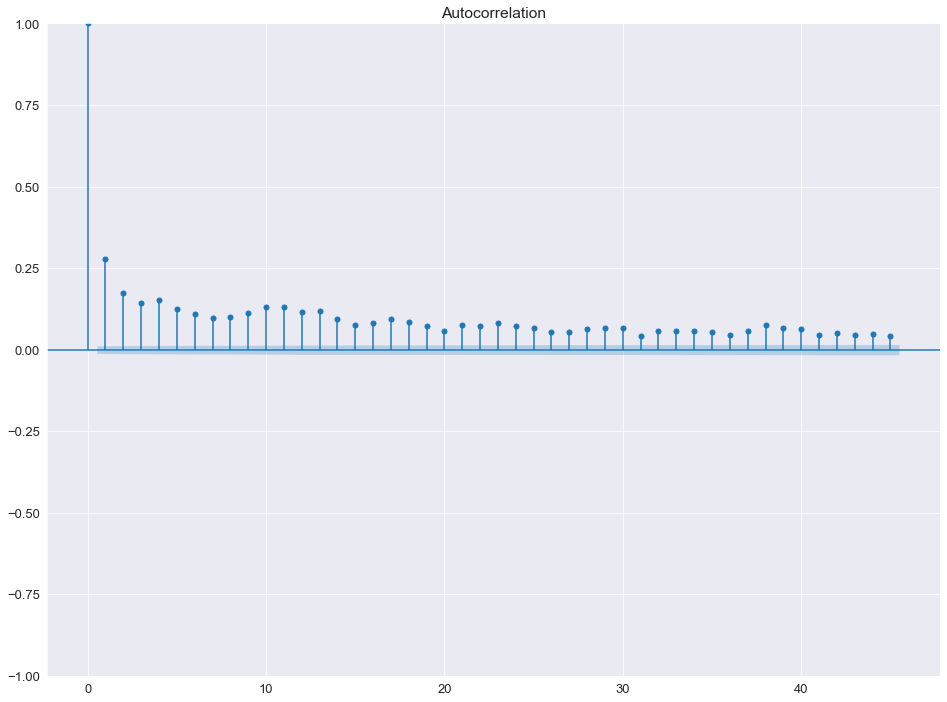

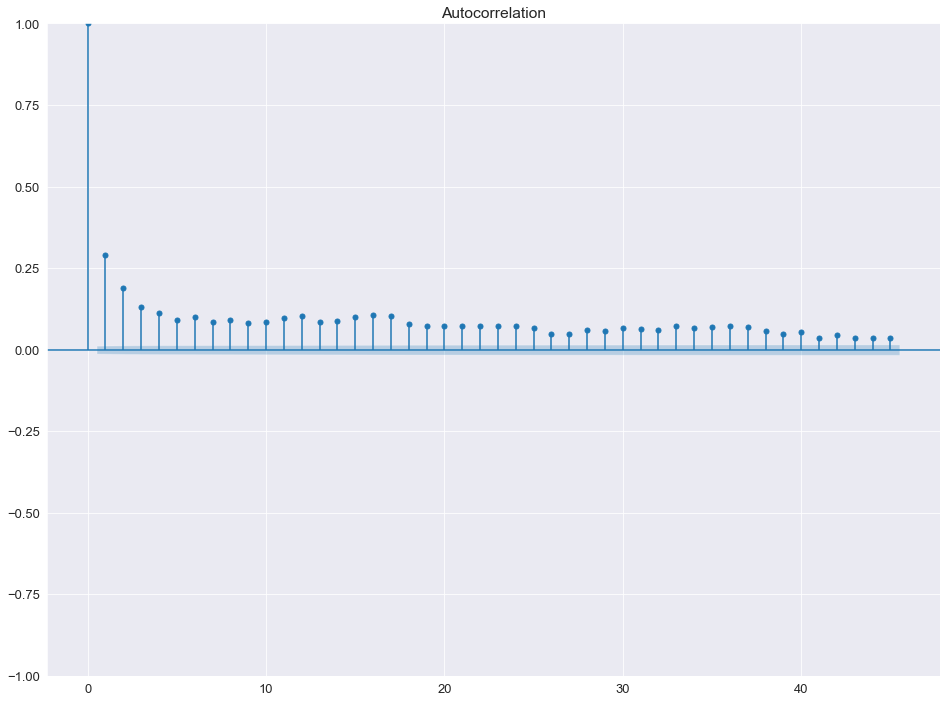

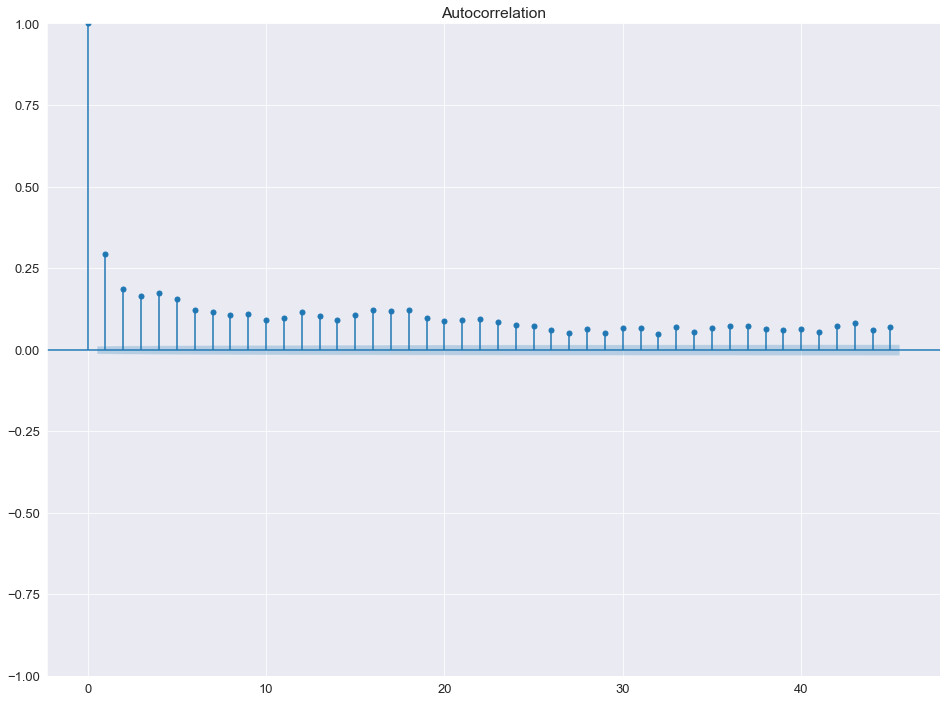

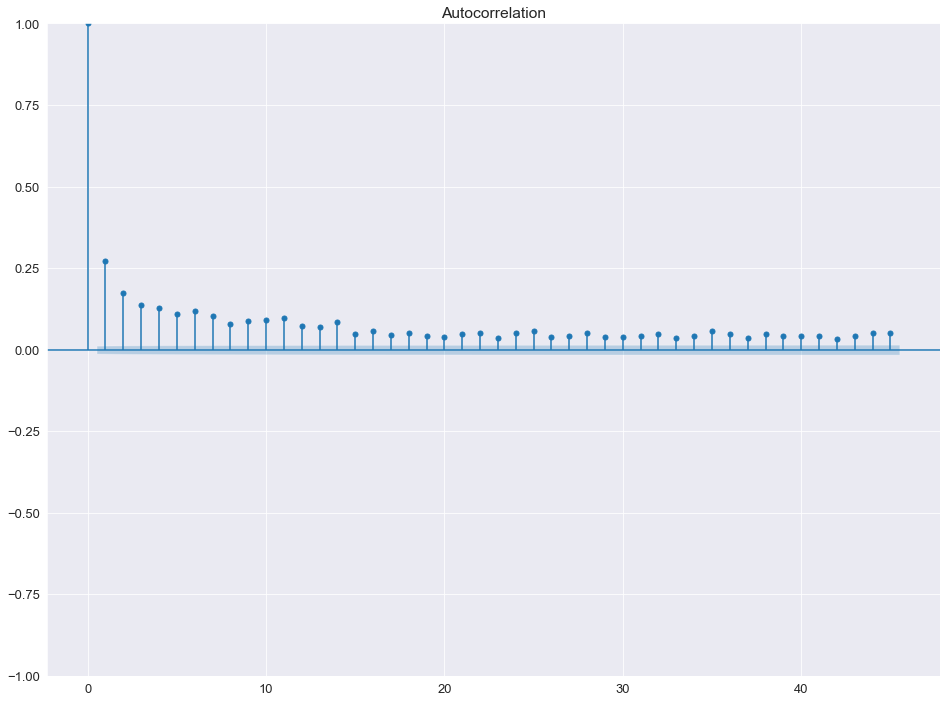

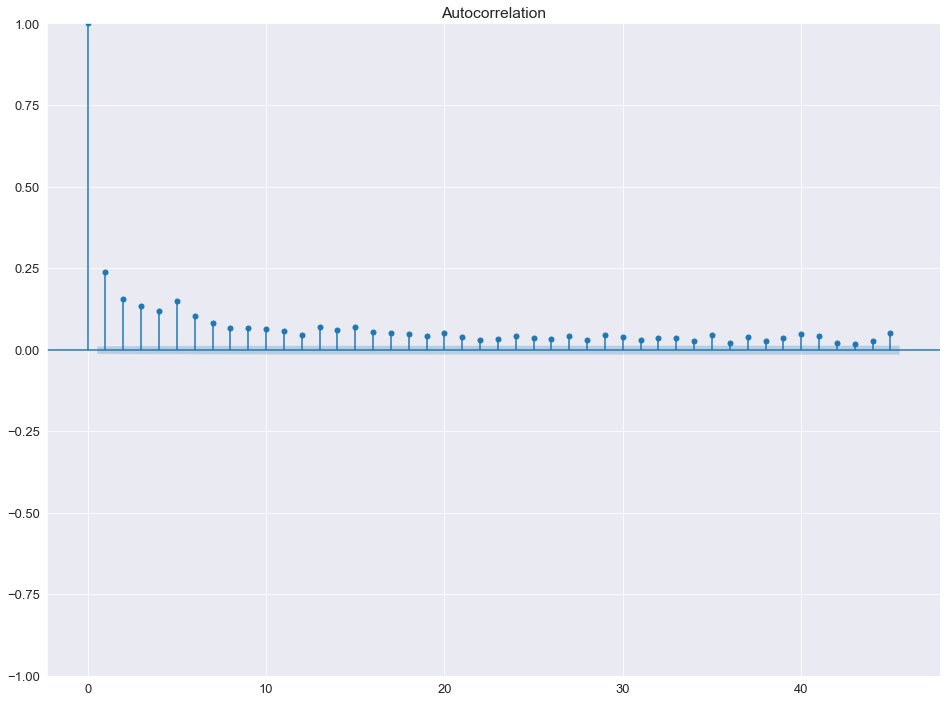

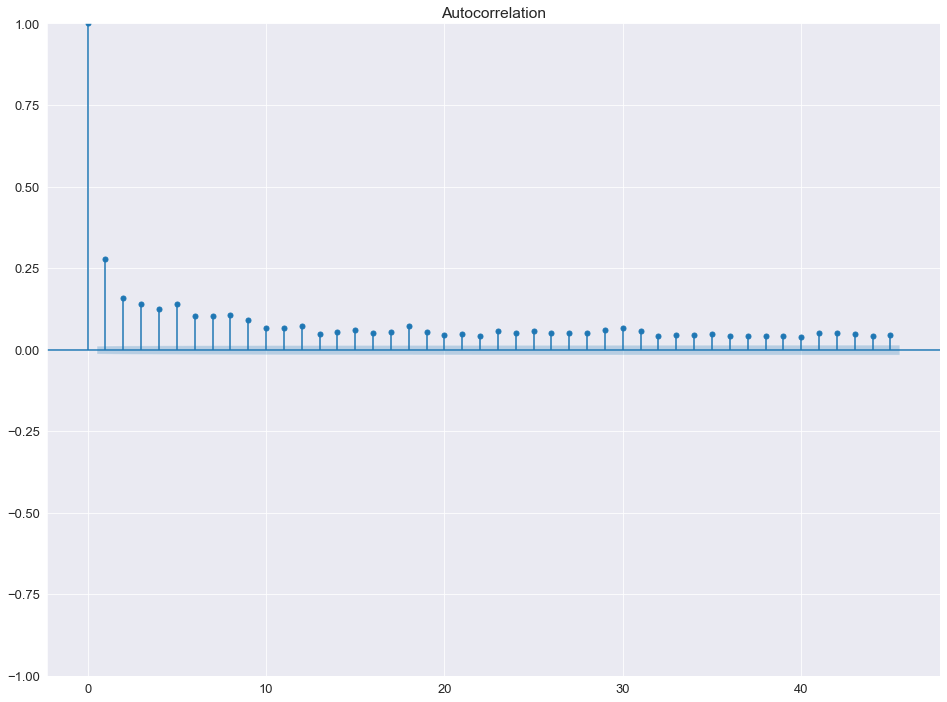

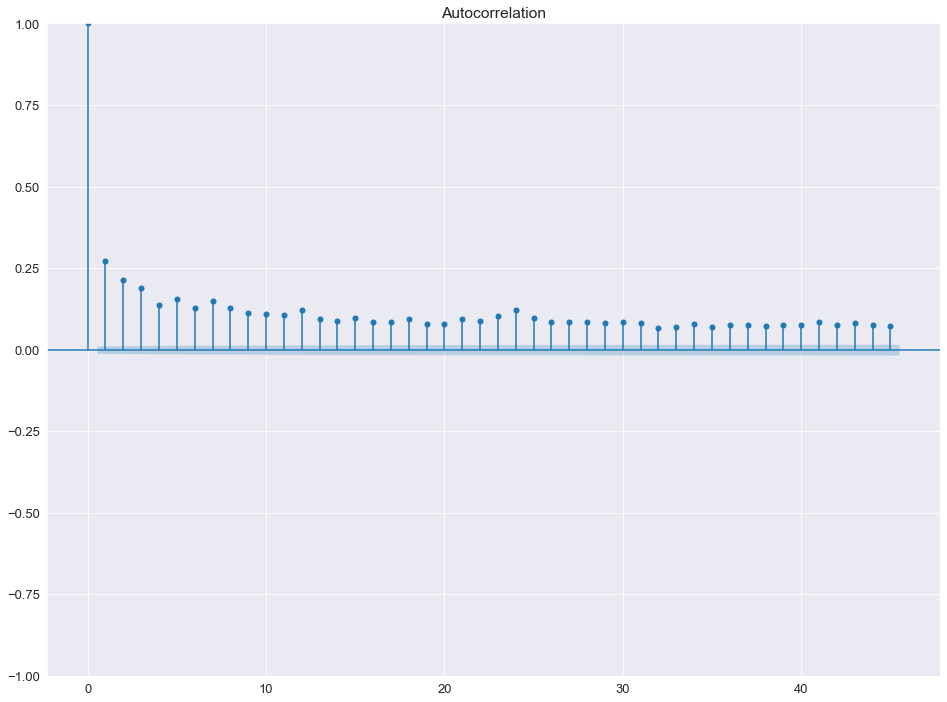

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(10):
    plot_acf(log_pr_10.iloc[1:, i]**2)

very long term dependency of the variance...

## Modelling

In [43]:
# split train and test
t_split = 144 * 30 # last month as test data
log_pr_train = log_pr_10.iloc[:-t_split]
log_pr_test = log_pr_10.iloc[-t_split:]

vol_pr_train = vol_pr_5.iloc[:-t_split]
vol_pr_test = vol_pr_5.iloc[-t_split:]

In [79]:
# Import Statsmodels
from statsmodels.tsa.api import VAR

model = VAR(vol_pr_train)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-45.42,-45.42,1.873e-20,-45.42
1,-59.61,-59.57,1.290e-26,-59.60
2,-59.70,-59.62,1.188e-26,-59.67
3,-59.72,-59.61,1.156e-26,-59.69
4,-59.73,-59.58,1.151e-26,-59.68
5,-59.76,-59.57,1.113e-26,-59.70
6,-60.38,-60.16*,5.998e-27,-60.31
7,-60.38,-60.12,5.992e-27,-60.30
8,-60.38,-60.08,6.001e-27,-60.28
9,-60.38,-60.05,5.983e-27,-60.27


Choose order to be 16

In [49]:
model_fitted = model.fit(16)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Apr, 2022
Time:                     10:47:46
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -59.8798
Nobs:                     21955.0    HQIC:                  -60.2752
Log likelihood:           353850.    FPE:                5.49372e-27
AIC:                     -60.4662    Det(Omega_mle):     5.10664e-27
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.009768         0.001591            6.141           0.000
L1.0          0.943609         0.006837          138.014           0.000
L1.1          0.032703         0.006904            4.737           0.000
L1.2          0.008326 

#### Durbin Watson Test
test for correlation in the residual

In [50]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(vol_pr_train.columns, out):
    print(adjust(col), ':', round(val, 2))

0      : 2.0
1      : 2.0
2      : 2.0
3      : 2.0
4      : 2.0
5      : 2.0
6      : 2.0
7      : 2.0
8      : 2.0
9      : 2.0


there is no remianing correlation, we can proceed to prediction

#### Prediction

In [86]:
dt = 100
step = 3

predict_1 = model_fitted.forecast(vol_pr_train.iloc[:dt].values, step)

In [87]:
# rmse
from sklearn.metrics import mean_squared_error as mse

[np.sqrt(mse(vol_pr_train.iloc[dt:(dt+step),i].values, predict_1.T[i])) for i in range(10)]

[0.12162033100310272,
 0.04456425278768311,
 0.031164229889136315,
 0.009334485393283474,
 0.027498385907592474,
 0.037076906154835526,
 0.02563460987170867,
 0.026265956914641685,
 0.020380531882690976,
 0.024368373270137453]

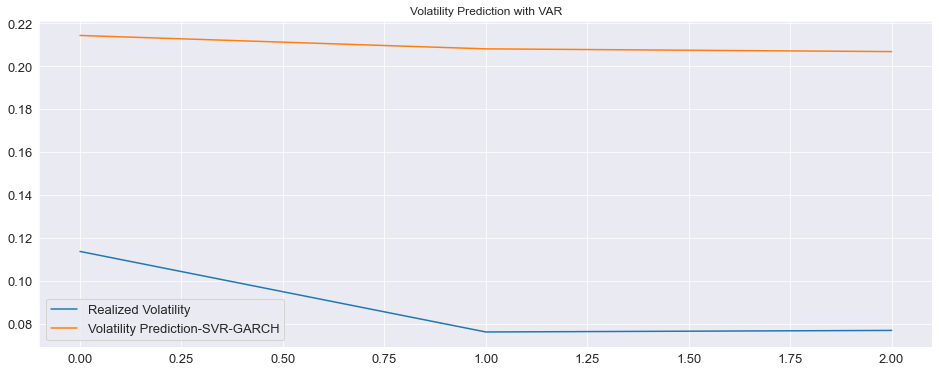

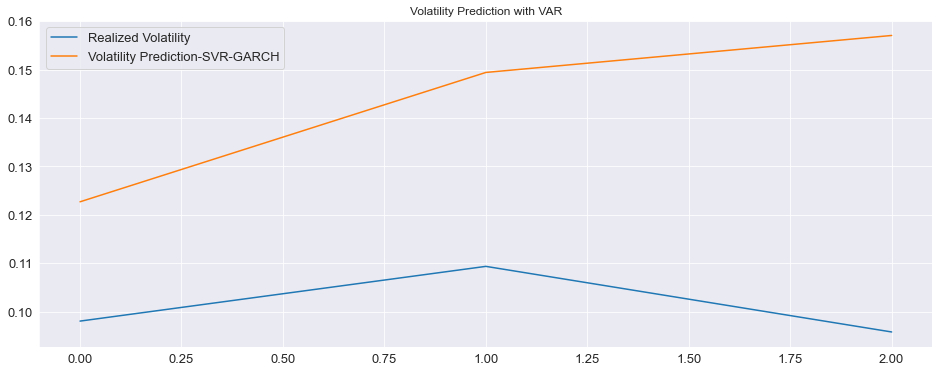

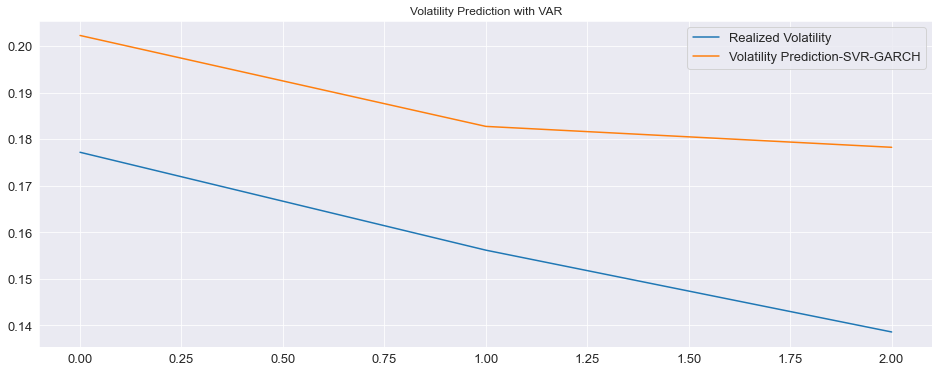

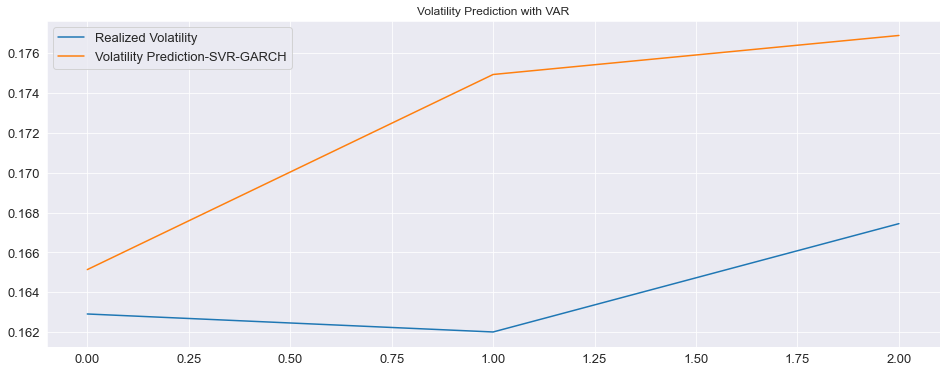

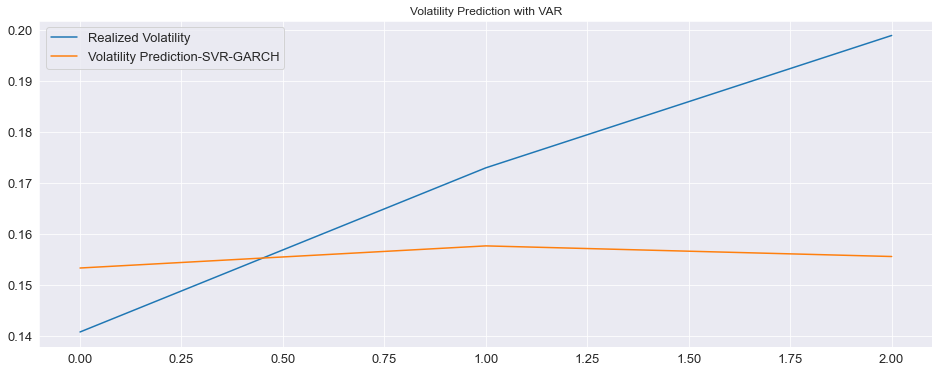

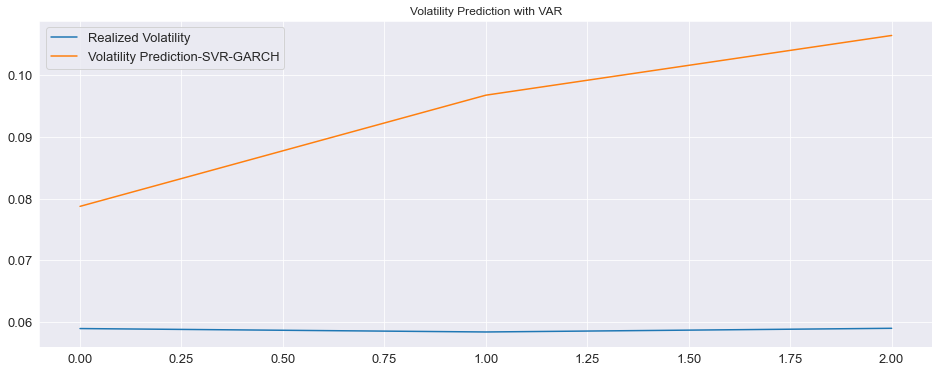

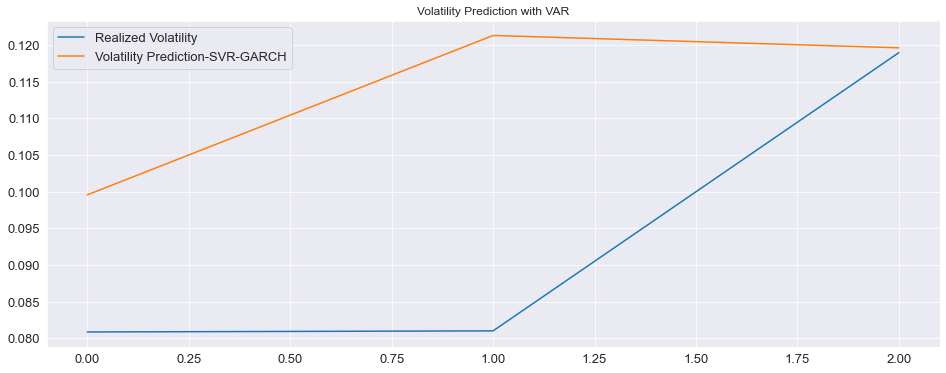

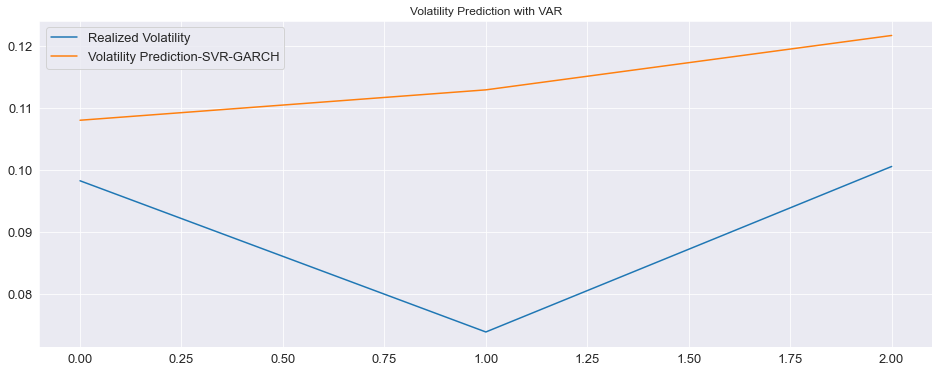

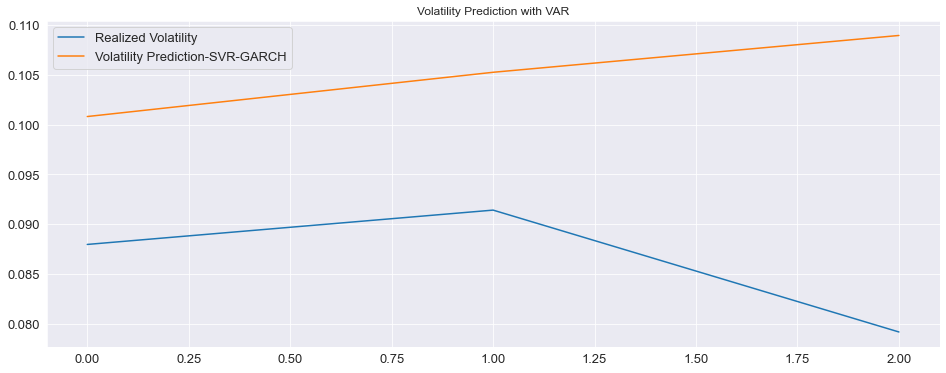

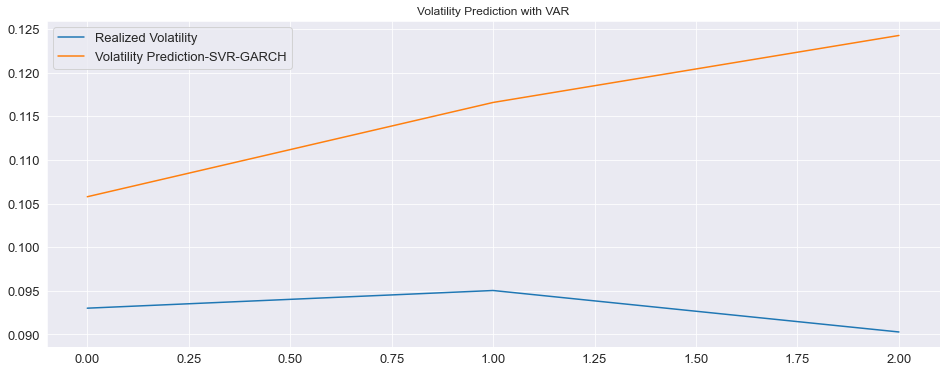

In [88]:
for i in range(10):

    plt.figure(figsize=(16, 6))
    plt.plot(vol_pr_train.iloc[dt:(dt+step),i].values, label='Realized Volatility')
    plt.plot(predict_1.T[i], label='Volatility Prediction-SVR-GARCH')
    plt.title('Volatility Prediction with VAR', fontsize=12)
    plt.legend()
    plt.show()

In [ ]:
#  def test(self, X_pr, X_volu=None, step=30):
#         """
#         X_pr, X_volu (series data frame): test data indexed with time 
#         provided with 1 day of data, forward predict 'steps' mins log return
#         """
#         t0 = time.time()
#         dt = datetime.timedelta(days=1)
#         r_hat = pd.DataFrame(index=X_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
#         r_fwd = (X_pr.shift(-30) - X_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})

#         for t in X_pr.index[30::]: # compute the predictions every 10 minutes
#             r_hat.loc[t, :] = model_fitted.forecast(X_pr.loc[(t - dt):t], 5)
#             model_fitted.plot_forecast(5)
#             # r_hat.loc[t, :] = self.forward(X_pr.loc[(t - dt):t], X_volu.loc[(t - dt):t])
#             # print("rmse of the prediction is ", self.rmse(X_pr.loc[(t-dt+step):(t+step)]))

#         t_used = time.time() - t0
#         print("time used: ", t_used)
#         # 
#         r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
#         r_hat_all = r_hat.iloc[:-3].values.ravel()
#         print("Final corr is ", np.corrcoef(r_fwd_all, r_hat_all)[0, 1])

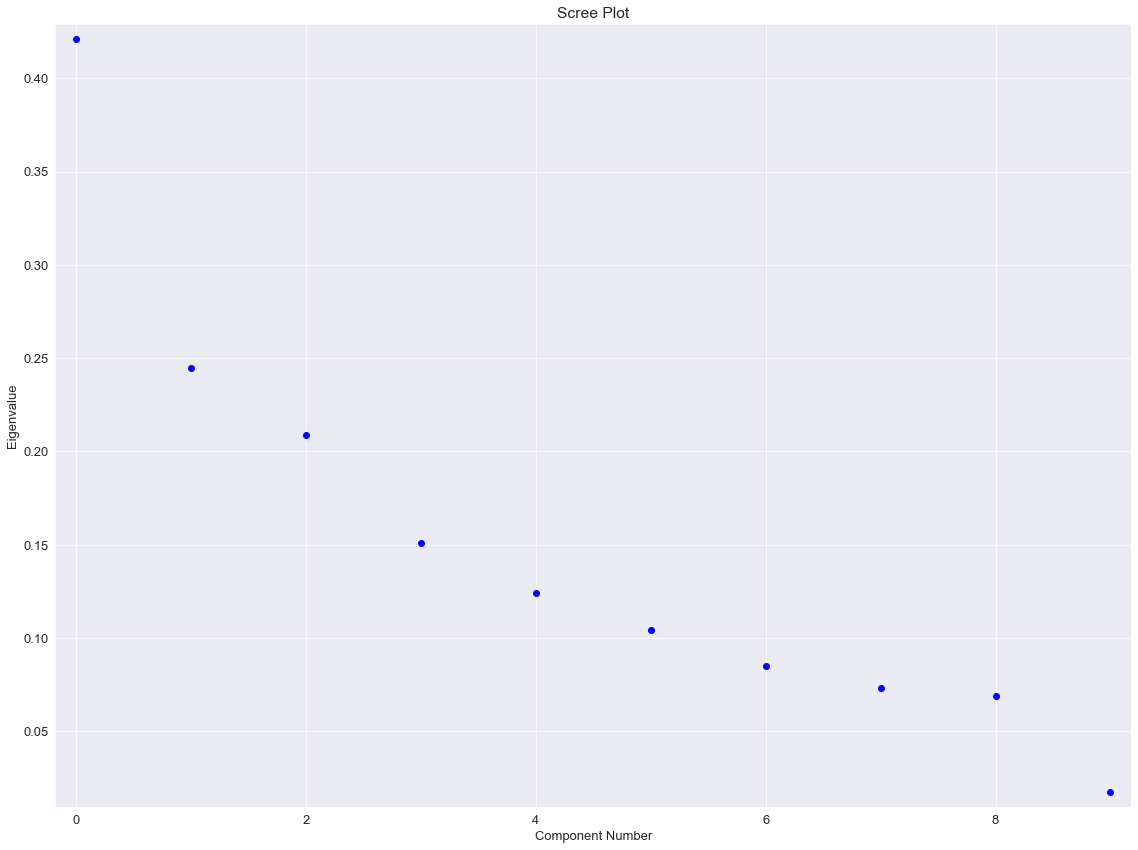

In [20]:

from statsmodels.multivariate.pca import PCA

week_t = 144 * 30 + 1

pca = PCA(log_pr_10.diff().iloc[1:week_t,:], standardize=False, demean=True)
fig = pca.plot_scree(log_scale=False)

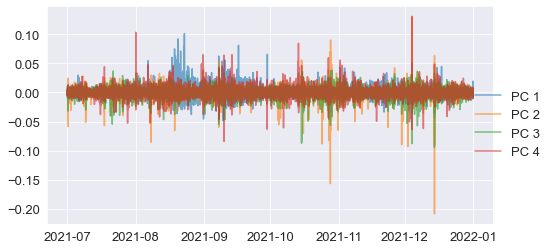

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
lines = ax.plot(pca.factors.iloc[:, :4], alpha=0.6)
# ax.set_xticklabels(log_pr_10.columns.values[::10])
# ax.set_xlim(0, 51)
# fig.subplots_adjust(0.1, 0.1, 0.85, 0.9)
legend = fig.legend(lines, ["PC 1", "PC 2", "PC 3", "PC 4"], loc="center right")
legend.draw_frame(False)

In [51]:
idx = pca.loadings.iloc[:, 0].argsort()

def make_plot(labels):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax = log_pr_10.iloc[:,labels].plot(legend=False, grid=False, ax=ax)
    # log_pr_10.mean().plot(ax=ax, grid=False, label="Mean")
    # ax.set_xlim(0, 51)
    # fig.subplots_adjust(0.1, 0.1, 0.75, 0.9)
    # ax.set_xlabel("Year", size=17)
    # ax.set_ylabel("Fertility", size=17)
    # legend = ax.legend(
    #     *ax.get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5)
    # )
    legend.draw_frame(False)

timestamp
2021-07-01 00:10:00    0.000142
2021-07-01 00:20:00   -0.000258
2021-07-01 00:30:00   -0.000043
2021-07-01 00:40:00    0.000618
2021-07-01 00:50:00    0.001759
                         ...   
2021-12-31 23:10:00    0.000027
2021-12-31 23:20:00    0.000407
2021-12-31 23:30:00    0.000482
2021-12-31 23:40:00   -0.000219
2021-12-31 23:50:00   -0.000040
Freq: 10T, Name: 9, Length: 26495, dtype: float64

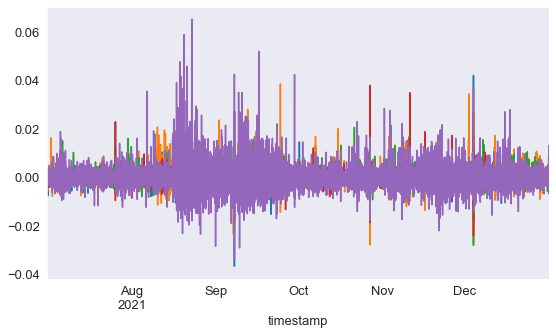

In [52]:
labels = log_pr_10.columns[idx[-5:]]
make_plot(labels)
lab = log_pr_10.columns[idx[-5:]]
log_pr_10.iloc[:,lab[0]]


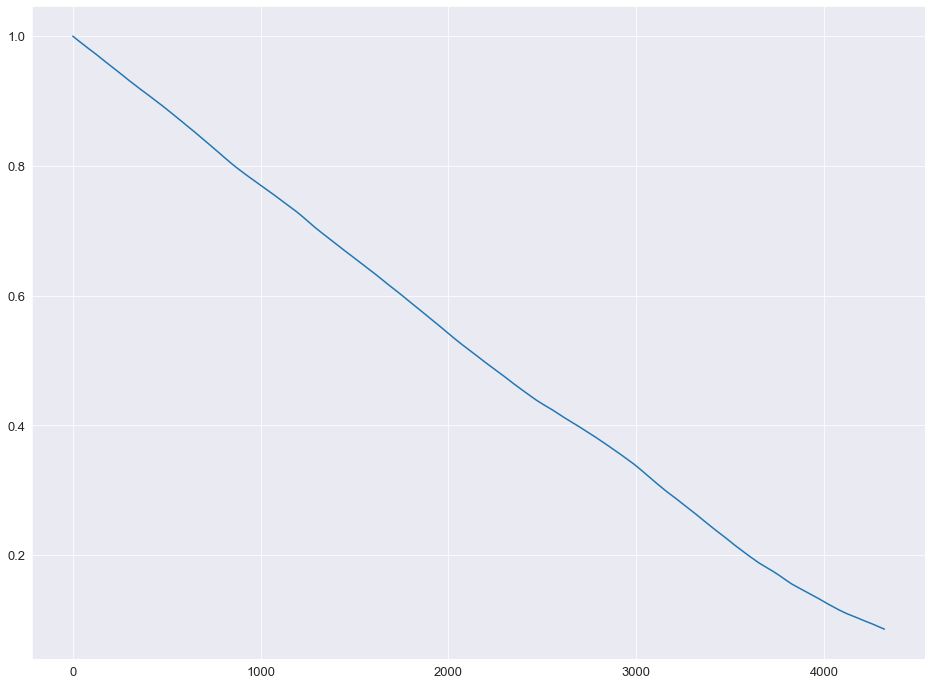

In [21]:
from statsmodels.tsa.stattools import acf
acf_0 = acf(log_pr_10[0], nlags=week_t)
plt.plot(acf_0)

In [4]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [11]:
log_pr.shape

(264960, 10)

In [6]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

4.823527812957764


In [7]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [8]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

0    0.028584
1    0.063681
2    0.005824
3    0.036314
4    0.096442
5    0.035261
6    0.067607
7    0.022329
8    0.105946
9    0.053176
dtype: float64

In [9]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)

array([[1.        , 0.04011869],
       [0.04011869, 1.        ]])

In [ ]:
np.corrcoef(r_fwd_all, r_hat_all)[0,1]